# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

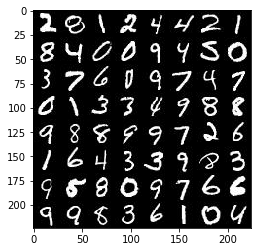

In [3]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

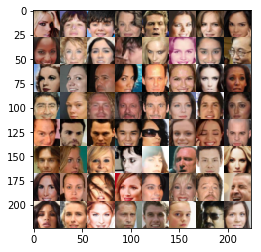

In [4]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/rtorres/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    r_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels),
                              name='r_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None, z_dim), name='z_input')
    lr = tf.placeholder(dtype=tf.float32, name='lr')

    return r_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.6):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: The leakage amount from the relus.
    :param dropout: How much dropout we want for trainning the discriminator
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        h1 = tf.maximum(alpha * h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha * h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha * h3, h3)

        flat = tf.reshape(h3, (-1, 4096))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)
        
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :param alpha: The leakage amount from the relus.
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 3*3*512)
        h1 = tf.reshape(h1, (-1, 3, 3, 512))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 = tf.maximum(alpha * h1, h1)
        # 3x3x512
        
        h2 = tf.layers.conv2d_transpose(h1, 256, kernel_size=4, strides=2, padding='same')
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2)
        # 6x6x256
        
        h3 = tf.layers.conv2d_transpose(h2, 128, kernel_size=4, strides=2, padding='valid')
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3)
        #14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, kernel_size=5,strides=2, padding='same')
        out = tf.tanh(logits)
        # 28x28x5
        
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, dropout=0.6, smooth=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :param alpha: The leakage amount from the relus.
    :param dropout: How much dropout we want for trainning the discriminator
    :param smooth: How much do we want to smooth the discriminator so it is not that strong.
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, dropout=dropout)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, dropout=dropout)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_step = 10
    show_step = 100
    leaky_alpha = 0.2
    dropout = 0.6
    images_to_show = 20
    losses =[]
    step = 0
    
    
    
    _, width, height, channels = data_shape
    
    r_input, z_input, lr = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(r_input, z_input, channels, alpha=leaky_alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print("Starting trainning")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                batch_images = 2*batch_images
                # Random Noise as input
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={r_input: batch_images, z_input: z_batch, lr: learning_rate})
                # Let the generator run twice, so that the discriminator does not converge that fast.
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z_batch, r_input: batch_images, lr: learning_rate})
                
                if step % print_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_batch, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_batch})
                    
                    print("Step: {}:".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_input, channels, data_image_mode)
    print("Finished with trainning")
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting trainning
Step: 10: Epoch 1/3... Discriminator Loss: 2.4541... Generator Loss: 0.2737
Step: 20: Epoch 1/3... Discriminator Loss: 2.7714... Generator Loss: 0.7020
Step: 30: Epoch 1/3... Discriminator Loss: 1.3990... Generator Loss: 0.7323
Step: 40: Epoch 1/3... Discriminator Loss: 0.7252... Generator Loss: 1.5914
Step: 50: Epoch 1/3... Discriminator Loss: 1.1043... Generator Loss: 1.0252
Step: 60: Epoch 1/3... Discriminator Loss: 1.3201... Generator Loss: 0.8935
Step: 70: Epoch 1/3... Discriminator Loss: 0.6583... Generator Loss: 1.3122
Step: 80: Epoch 1/3... Discriminator Loss: 0.8016... Generator Loss: 1.1850
Step: 90: Epoch 1/3... Discriminator Loss: 1.0217... Generator Loss: 1.1106
Step: 100: Epoch 1/3... Discriminator Loss: 1.2788... Generator Loss: 0.8861


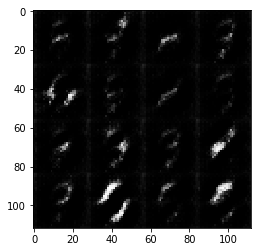

Step: 110: Epoch 1/3... Discriminator Loss: 0.7505... Generator Loss: 1.9536
Step: 120: Epoch 1/3... Discriminator Loss: 1.0126... Generator Loss: 0.9096
Step: 130: Epoch 1/3... Discriminator Loss: 2.3928... Generator Loss: 0.7337
Step: 140: Epoch 1/3... Discriminator Loss: 1.4633... Generator Loss: 0.6646
Step: 150: Epoch 1/3... Discriminator Loss: 1.2118... Generator Loss: 0.6547
Step: 160: Epoch 1/3... Discriminator Loss: 1.5527... Generator Loss: 1.3332
Step: 170: Epoch 1/3... Discriminator Loss: 1.1122... Generator Loss: 0.8498
Step: 180: Epoch 1/3... Discriminator Loss: 1.2422... Generator Loss: 0.5851
Step: 190: Epoch 1/3... Discriminator Loss: 1.2628... Generator Loss: 0.8269
Step: 200: Epoch 1/3... Discriminator Loss: 1.5512... Generator Loss: 0.5252


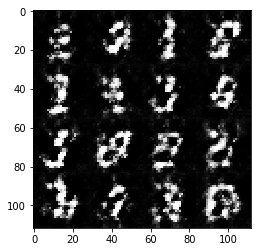

Step: 210: Epoch 1/3... Discriminator Loss: 1.3086... Generator Loss: 0.8023
Step: 220: Epoch 1/3... Discriminator Loss: 1.2244... Generator Loss: 0.7424
Step: 230: Epoch 1/3... Discriminator Loss: 1.3753... Generator Loss: 0.5963
Step: 240: Epoch 1/3... Discriminator Loss: 1.1905... Generator Loss: 0.7521
Step: 250: Epoch 1/3... Discriminator Loss: 1.4304... Generator Loss: 0.6319
Step: 260: Epoch 1/3... Discriminator Loss: 1.3199... Generator Loss: 0.4889
Step: 270: Epoch 1/3... Discriminator Loss: 1.3357... Generator Loss: 0.4309
Step: 280: Epoch 1/3... Discriminator Loss: 1.2076... Generator Loss: 0.7895
Step: 290: Epoch 1/3... Discriminator Loss: 1.2898... Generator Loss: 0.9873
Step: 300: Epoch 1/3... Discriminator Loss: 1.1655... Generator Loss: 1.4902


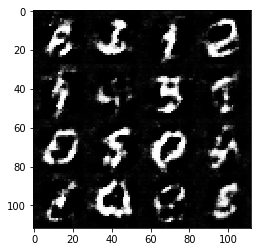

Step: 310: Epoch 1/3... Discriminator Loss: 1.0735... Generator Loss: 0.7879
Step: 320: Epoch 1/3... Discriminator Loss: 1.3170... Generator Loss: 0.4453
Step: 330: Epoch 1/3... Discriminator Loss: 1.2628... Generator Loss: 1.1175
Step: 340: Epoch 1/3... Discriminator Loss: 1.0469... Generator Loss: 0.9194
Step: 350: Epoch 1/3... Discriminator Loss: 1.3767... Generator Loss: 1.5746
Step: 360: Epoch 1/3... Discriminator Loss: 1.1996... Generator Loss: 1.1851
Step: 370: Epoch 1/3... Discriminator Loss: 1.2607... Generator Loss: 1.4133
Step: 380: Epoch 1/3... Discriminator Loss: 1.2035... Generator Loss: 0.6822
Step: 390: Epoch 1/3... Discriminator Loss: 1.3252... Generator Loss: 0.4908
Step: 400: Epoch 1/3... Discriminator Loss: 1.1958... Generator Loss: 0.5969


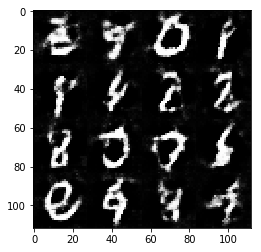

Step: 410: Epoch 1/3... Discriminator Loss: 1.2280... Generator Loss: 0.5880
Step: 420: Epoch 1/3... Discriminator Loss: 1.3257... Generator Loss: 0.4703
Step: 430: Epoch 1/3... Discriminator Loss: 1.2173... Generator Loss: 0.5281
Step: 440: Epoch 1/3... Discriminator Loss: 1.4134... Generator Loss: 0.4026
Step: 450: Epoch 1/3... Discriminator Loss: 1.2131... Generator Loss: 0.7044
Step: 460: Epoch 1/3... Discriminator Loss: 1.6601... Generator Loss: 0.2752
Step: 470: Epoch 2/3... Discriminator Loss: 1.3444... Generator Loss: 0.4539
Step: 480: Epoch 2/3... Discriminator Loss: 1.1752... Generator Loss: 0.8497
Step: 490: Epoch 2/3... Discriminator Loss: 1.2001... Generator Loss: 0.9331
Step: 500: Epoch 2/3... Discriminator Loss: 1.5198... Generator Loss: 0.3574


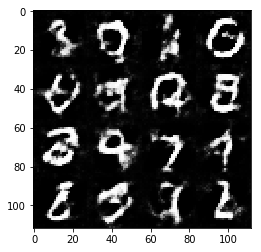

Step: 510: Epoch 2/3... Discriminator Loss: 1.2217... Generator Loss: 0.6553
Step: 520: Epoch 2/3... Discriminator Loss: 1.7744... Generator Loss: 0.2380
Step: 530: Epoch 2/3... Discriminator Loss: 1.2876... Generator Loss: 0.8625
Step: 540: Epoch 2/3... Discriminator Loss: 1.1898... Generator Loss: 1.0015
Step: 550: Epoch 2/3... Discriminator Loss: 1.2054... Generator Loss: 0.6666
Step: 560: Epoch 2/3... Discriminator Loss: 1.2872... Generator Loss: 0.6099
Step: 570: Epoch 2/3... Discriminator Loss: 1.2163... Generator Loss: 1.0583
Step: 580: Epoch 2/3... Discriminator Loss: 1.3739... Generator Loss: 0.4295
Step: 590: Epoch 2/3... Discriminator Loss: 1.3501... Generator Loss: 1.0755
Step: 600: Epoch 2/3... Discriminator Loss: 1.2103... Generator Loss: 0.8310


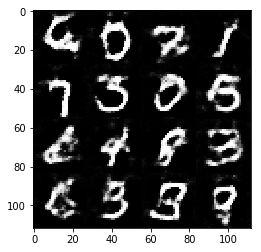

Step: 610: Epoch 2/3... Discriminator Loss: 1.3019... Generator Loss: 0.5065
Step: 620: Epoch 2/3... Discriminator Loss: 1.3107... Generator Loss: 0.5521
Step: 630: Epoch 2/3... Discriminator Loss: 1.4521... Generator Loss: 0.4133
Step: 640: Epoch 2/3... Discriminator Loss: 1.2041... Generator Loss: 0.6996
Step: 650: Epoch 2/3... Discriminator Loss: 1.2592... Generator Loss: 0.9137
Step: 660: Epoch 2/3... Discriminator Loss: 1.2152... Generator Loss: 0.8157
Step: 670: Epoch 2/3... Discriminator Loss: 1.2681... Generator Loss: 0.6753
Step: 680: Epoch 2/3... Discriminator Loss: 1.3343... Generator Loss: 0.4917
Step: 690: Epoch 2/3... Discriminator Loss: 1.2168... Generator Loss: 0.8641
Step: 700: Epoch 2/3... Discriminator Loss: 1.2197... Generator Loss: 0.9293


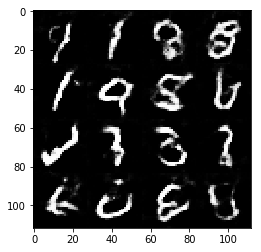

Step: 710: Epoch 2/3... Discriminator Loss: 1.3134... Generator Loss: 0.4929
Step: 720: Epoch 2/3... Discriminator Loss: 1.3234... Generator Loss: 1.0221
Step: 730: Epoch 2/3... Discriminator Loss: 1.2553... Generator Loss: 1.0802
Step: 740: Epoch 2/3... Discriminator Loss: 1.2774... Generator Loss: 0.8492
Step: 750: Epoch 2/3... Discriminator Loss: 1.2996... Generator Loss: 0.8456
Step: 760: Epoch 2/3... Discriminator Loss: 1.2690... Generator Loss: 0.6485
Step: 770: Epoch 2/3... Discriminator Loss: 1.2946... Generator Loss: 0.9329
Step: 780: Epoch 2/3... Discriminator Loss: 1.2025... Generator Loss: 0.7962
Step: 790: Epoch 2/3... Discriminator Loss: 1.4357... Generator Loss: 0.4220
Step: 800: Epoch 2/3... Discriminator Loss: 1.2619... Generator Loss: 0.5729


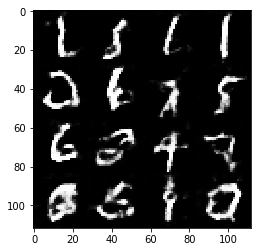

Step: 810: Epoch 2/3... Discriminator Loss: 1.3400... Generator Loss: 0.5303
Step: 820: Epoch 2/3... Discriminator Loss: 1.3252... Generator Loss: 0.5310
Step: 830: Epoch 2/3... Discriminator Loss: 1.3319... Generator Loss: 1.2403
Step: 840: Epoch 2/3... Discriminator Loss: 1.2007... Generator Loss: 0.7423
Step: 850: Epoch 2/3... Discriminator Loss: 1.3609... Generator Loss: 0.4570
Step: 860: Epoch 2/3... Discriminator Loss: 1.2535... Generator Loss: 0.6528
Step: 870: Epoch 2/3... Discriminator Loss: 1.3814... Generator Loss: 0.3873
Step: 880: Epoch 2/3... Discriminator Loss: 1.3982... Generator Loss: 0.3962
Step: 890: Epoch 2/3... Discriminator Loss: 1.3362... Generator Loss: 0.5165
Step: 900: Epoch 2/3... Discriminator Loss: 1.2648... Generator Loss: 0.5162


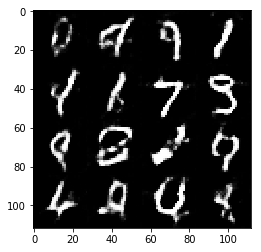

Step: 910: Epoch 2/3... Discriminator Loss: 1.3740... Generator Loss: 0.4547
Step: 920: Epoch 2/3... Discriminator Loss: 1.2624... Generator Loss: 0.8939
Step: 930: Epoch 2/3... Discriminator Loss: 1.3698... Generator Loss: 1.4776
Step: 940: Epoch 3/3... Discriminator Loss: 1.2400... Generator Loss: 0.5645
Step: 950: Epoch 3/3... Discriminator Loss: 1.5572... Generator Loss: 0.3167
Step: 960: Epoch 3/3... Discriminator Loss: 1.2989... Generator Loss: 0.5150
Step: 970: Epoch 3/3... Discriminator Loss: 1.5472... Generator Loss: 1.2521
Step: 980: Epoch 3/3... Discriminator Loss: 1.2400... Generator Loss: 0.6902
Step: 990: Epoch 3/3... Discriminator Loss: 1.2194... Generator Loss: 0.8535
Step: 1000: Epoch 3/3... Discriminator Loss: 1.3323... Generator Loss: 1.2714


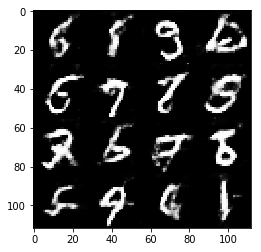

Step: 1010: Epoch 3/3... Discriminator Loss: 1.1970... Generator Loss: 0.8389
Step: 1020: Epoch 3/3... Discriminator Loss: 1.3355... Generator Loss: 0.4736
Step: 1030: Epoch 3/3... Discriminator Loss: 1.2399... Generator Loss: 0.5923
Step: 1040: Epoch 3/3... Discriminator Loss: 1.3962... Generator Loss: 1.3034
Step: 1050: Epoch 3/3... Discriminator Loss: 1.2156... Generator Loss: 0.7151
Step: 1060: Epoch 3/3... Discriminator Loss: 1.2428... Generator Loss: 0.5419
Step: 1070: Epoch 3/3... Discriminator Loss: 1.3880... Generator Loss: 0.4266
Step: 1080: Epoch 3/3... Discriminator Loss: 1.3701... Generator Loss: 0.4605
Step: 1090: Epoch 3/3... Discriminator Loss: 1.7342... Generator Loss: 1.1614
Step: 1100: Epoch 3/3... Discriminator Loss: 1.4249... Generator Loss: 0.7035


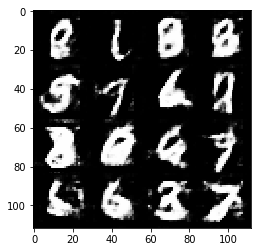

Step: 1110: Epoch 3/3... Discriminator Loss: 1.1808... Generator Loss: 0.6699
Step: 1120: Epoch 3/3... Discriminator Loss: 1.3028... Generator Loss: 1.0006
Step: 1130: Epoch 3/3... Discriminator Loss: 1.2833... Generator Loss: 0.5617
Step: 1140: Epoch 3/3... Discriminator Loss: 1.7943... Generator Loss: 0.2230
Step: 1150: Epoch 3/3... Discriminator Loss: 1.3303... Generator Loss: 0.7038
Step: 1160: Epoch 3/3... Discriminator Loss: 1.2695... Generator Loss: 0.7691
Step: 1170: Epoch 3/3... Discriminator Loss: 1.4452... Generator Loss: 0.4946
Step: 1180: Epoch 3/3... Discriminator Loss: 1.2362... Generator Loss: 0.6382
Step: 1190: Epoch 3/3... Discriminator Loss: 1.2122... Generator Loss: 0.5779
Step: 1200: Epoch 3/3... Discriminator Loss: 1.5128... Generator Loss: 0.3372


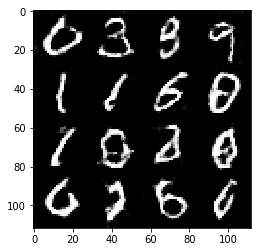

Step: 1210: Epoch 3/3... Discriminator Loss: 1.4971... Generator Loss: 0.9700
Step: 1220: Epoch 3/3... Discriminator Loss: 1.2466... Generator Loss: 0.6926
Step: 1230: Epoch 3/3... Discriminator Loss: 1.2897... Generator Loss: 0.5023
Step: 1240: Epoch 3/3... Discriminator Loss: 1.2885... Generator Loss: 0.6452
Step: 1250: Epoch 3/3... Discriminator Loss: 1.3043... Generator Loss: 0.5967
Step: 1260: Epoch 3/3... Discriminator Loss: 1.5870... Generator Loss: 0.3146
Step: 1270: Epoch 3/3... Discriminator Loss: 1.2401... Generator Loss: 0.6599
Step: 1280: Epoch 3/3... Discriminator Loss: 1.3976... Generator Loss: 0.4423
Step: 1290: Epoch 3/3... Discriminator Loss: 1.2660... Generator Loss: 0.5359
Step: 1300: Epoch 3/3... Discriminator Loss: 2.1593... Generator Loss: 2.2678


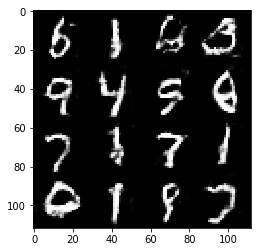

Step: 1310: Epoch 3/3... Discriminator Loss: 1.2250... Generator Loss: 0.8336
Step: 1320: Epoch 3/3... Discriminator Loss: 1.3369... Generator Loss: 0.5427
Step: 1330: Epoch 3/3... Discriminator Loss: 1.2286... Generator Loss: 0.5740
Step: 1340: Epoch 3/3... Discriminator Loss: 1.4476... Generator Loss: 0.3530
Step: 1350: Epoch 3/3... Discriminator Loss: 1.2760... Generator Loss: 0.6241
Step: 1360: Epoch 3/3... Discriminator Loss: 1.3805... Generator Loss: 0.4346
Step: 1370: Epoch 3/3... Discriminator Loss: 1.3433... Generator Loss: 0.6676
Step: 1380: Epoch 3/3... Discriminator Loss: 1.4113... Generator Loss: 0.4301
Step: 1390: Epoch 3/3... Discriminator Loss: 1.3728... Generator Loss: 0.4584
Step: 1400: Epoch 3/3... Discriminator Loss: 1.4569... Generator Loss: 0.3783


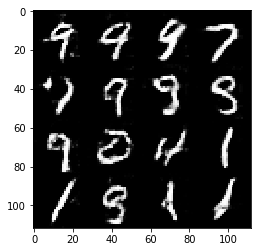

Finished with trainning


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Starting trainning
Step: 10: Epoch 1/2... Discriminator Loss: 3.3461... Generator Loss: 1.1971
Step: 20: Epoch 1/2... Discriminator Loss: 3.0682... Generator Loss: 0.1860
Step: 30: Epoch 1/2... Discriminator Loss: 1.9246... Generator Loss: 0.7473
Step: 40: Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 1.0822
Step: 50: Epoch 1/2... Discriminator Loss: 1.9571... Generator Loss: 0.3650
Step: 60: Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.3758
Step: 70: Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 0.3695
Step: 80: Epoch 1/2... Discriminator Loss: 1.6477... Generator Loss: 0.6607
Step: 90: Epoch 1/2... Discriminator Loss: 1.9791... Generator Loss: 0.4982
Step: 100: Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.9589


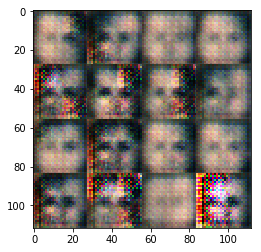

Step: 110: Epoch 1/2... Discriminator Loss: 0.6357... Generator Loss: 1.2916
Step: 120: Epoch 1/2... Discriminator Loss: 1.6687... Generator Loss: 0.6349
Step: 130: Epoch 1/2... Discriminator Loss: 1.9188... Generator Loss: 0.5002
Step: 140: Epoch 1/2... Discriminator Loss: 1.5911... Generator Loss: 0.8268
Step: 150: Epoch 1/2... Discriminator Loss: 2.6046... Generator Loss: 2.0114
Step: 160: Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 0.8118
Step: 170: Epoch 1/2... Discriminator Loss: 1.8661... Generator Loss: 0.3615
Step: 180: Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.5499
Step: 190: Epoch 1/2... Discriminator Loss: 1.4900... Generator Loss: 0.8365
Step: 200: Epoch 1/2... Discriminator Loss: 1.5986... Generator Loss: 0.5973


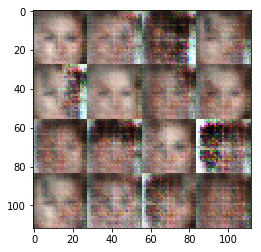

Step: 210: Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.6577
Step: 220: Epoch 1/2... Discriminator Loss: 1.4618... Generator Loss: 0.6069
Step: 230: Epoch 1/2... Discriminator Loss: 1.5048... Generator Loss: 0.6190
Step: 240: Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 0.6240
Step: 250: Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.8230
Step: 260: Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.6417
Step: 270: Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.5697
Step: 280: Epoch 1/2... Discriminator Loss: 1.3842... Generator Loss: 0.7274
Step: 290: Epoch 1/2... Discriminator Loss: 1.5459... Generator Loss: 0.7288
Step: 300: Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 0.6438


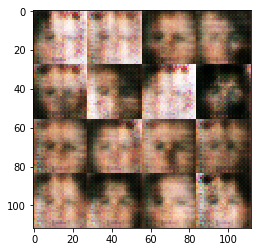

Step: 310: Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.6894
Step: 320: Epoch 1/2... Discriminator Loss: 1.4398... Generator Loss: 0.6856
Step: 330: Epoch 1/2... Discriminator Loss: 1.3777... Generator Loss: 0.5641
Step: 340: Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 0.6773
Step: 350: Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.6380
Step: 360: Epoch 1/2... Discriminator Loss: 1.5493... Generator Loss: 0.6225
Step: 370: Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.5898
Step: 380: Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.6730
Step: 390: Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 0.6982
Step: 400: Epoch 1/2... Discriminator Loss: 1.4286... Generator Loss: 0.6537


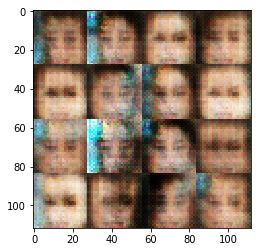

Step: 410: Epoch 1/2... Discriminator Loss: 1.6169... Generator Loss: 0.5395
Step: 420: Epoch 1/2... Discriminator Loss: 1.4263... Generator Loss: 0.5516
Step: 430: Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.7062
Step: 440: Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.6537
Step: 450: Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.7228
Step: 460: Epoch 1/2... Discriminator Loss: 1.5923... Generator Loss: 0.5448
Step: 470: Epoch 1/2... Discriminator Loss: 1.5974... Generator Loss: 0.5892
Step: 480: Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.6004
Step: 490: Epoch 1/2... Discriminator Loss: 1.6313... Generator Loss: 0.5977
Step: 500: Epoch 1/2... Discriminator Loss: 1.7726... Generator Loss: 0.9723


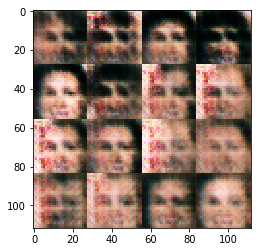

Step: 510: Epoch 1/2... Discriminator Loss: 1.5337... Generator Loss: 0.6336
Step: 520: Epoch 1/2... Discriminator Loss: 1.5422... Generator Loss: 0.5971
Step: 530: Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 0.6286
Step: 540: Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.6536
Step: 550: Epoch 1/2... Discriminator Loss: 1.5049... Generator Loss: 0.5708
Step: 560: Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.8345
Step: 570: Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 0.6542
Step: 580: Epoch 1/2... Discriminator Loss: 1.4568... Generator Loss: 0.6483
Step: 590: Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.7229
Step: 600: Epoch 1/2... Discriminator Loss: 1.5381... Generator Loss: 0.6175


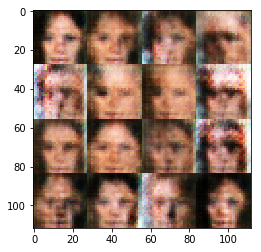

Step: 610: Epoch 1/2... Discriminator Loss: 1.4967... Generator Loss: 0.6009
Step: 620: Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.8103
Step: 630: Epoch 1/2... Discriminator Loss: 1.5286... Generator Loss: 0.7334
Step: 640: Epoch 1/2... Discriminator Loss: 1.4571... Generator Loss: 0.5092
Step: 650: Epoch 1/2... Discriminator Loss: 1.4910... Generator Loss: 0.5801
Step: 660: Epoch 1/2... Discriminator Loss: 1.4998... Generator Loss: 0.7093
Step: 670: Epoch 1/2... Discriminator Loss: 1.4345... Generator Loss: 0.6600
Step: 680: Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.7125
Step: 690: Epoch 1/2... Discriminator Loss: 1.4250... Generator Loss: 0.6703
Step: 700: Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.7046


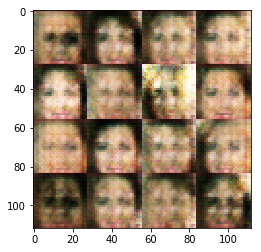

Step: 710: Epoch 1/2... Discriminator Loss: 1.4878... Generator Loss: 0.5641
Step: 720: Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.5733
Step: 730: Epoch 1/2... Discriminator Loss: 1.5402... Generator Loss: 0.6448
Step: 740: Epoch 1/2... Discriminator Loss: 1.5440... Generator Loss: 0.7224
Step: 750: Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.5473
Step: 760: Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 0.7086
Step: 770: Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.6759
Step: 780: Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.7601
Step: 790: Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.6698
Step: 800: Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.6190


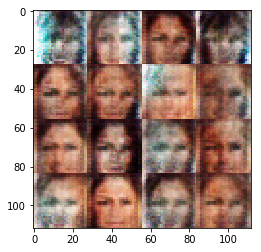

Step: 810: Epoch 1/2... Discriminator Loss: 1.7572... Generator Loss: 0.5987
Step: 820: Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.5735
Step: 830: Epoch 1/2... Discriminator Loss: 1.4129... Generator Loss: 0.6208
Step: 840: Epoch 1/2... Discriminator Loss: 1.5351... Generator Loss: 0.5831
Step: 850: Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.6931
Step: 860: Epoch 1/2... Discriminator Loss: 1.4210... Generator Loss: 0.5735
Step: 870: Epoch 1/2... Discriminator Loss: 1.5593... Generator Loss: 0.5949
Step: 880: Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.7008
Step: 890: Epoch 1/2... Discriminator Loss: 1.6450... Generator Loss: 0.5388
Step: 900: Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.8521


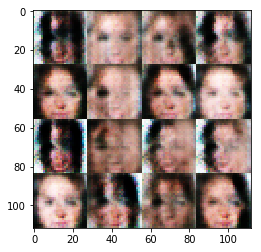

Step: 910: Epoch 1/2... Discriminator Loss: 1.4877... Generator Loss: 0.4926
Step: 920: Epoch 1/2... Discriminator Loss: 1.4386... Generator Loss: 0.8075
Step: 930: Epoch 1/2... Discriminator Loss: 1.4741... Generator Loss: 0.6679
Step: 940: Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.6285
Step: 950: Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.8635
Step: 960: Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.7056
Step: 970: Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.6765
Step: 980: Epoch 1/2... Discriminator Loss: 1.4747... Generator Loss: 0.7747
Step: 990: Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.6209
Step: 1000: Epoch 1/2... Discriminator Loss: 1.5810... Generator Loss: 0.7155


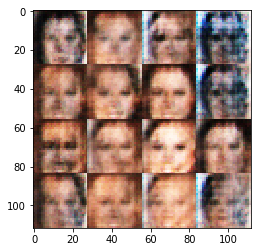

Step: 1010: Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.7863
Step: 1020: Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.5507
Step: 1030: Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.7203
Step: 1040: Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.6958
Step: 1050: Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 0.6181
Step: 1060: Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.7581
Step: 1070: Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 0.6855
Step: 1080: Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.6805
Step: 1090: Epoch 1/2... Discriminator Loss: 1.3904... Generator Loss: 0.6392
Step: 1100: Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.7332


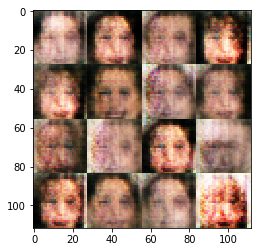

Step: 1110: Epoch 1/2... Discriminator Loss: 1.4422... Generator Loss: 0.7760
Step: 1120: Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.5948
Step: 1130: Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.5974
Step: 1140: Epoch 1/2... Discriminator Loss: 1.3858... Generator Loss: 0.7437
Step: 1150: Epoch 1/2... Discriminator Loss: 1.4913... Generator Loss: 0.6371
Step: 1160: Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.6669
Step: 1170: Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 0.5178
Step: 1180: Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 0.7257
Step: 1190: Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.7248
Step: 1200: Epoch 1/2... Discriminator Loss: 1.4593... Generator Loss: 0.7325


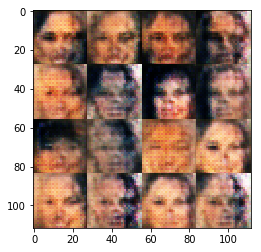

Step: 1210: Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.6165
Step: 1220: Epoch 1/2... Discriminator Loss: 1.4453... Generator Loss: 0.5777
Step: 1230: Epoch 1/2... Discriminator Loss: 1.4370... Generator Loss: 0.6847
Step: 1240: Epoch 1/2... Discriminator Loss: 1.5374... Generator Loss: 0.5498
Step: 1250: Epoch 1/2... Discriminator Loss: 1.5116... Generator Loss: 0.5812
Step: 1260: Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.6318
Step: 1270: Epoch 1/2... Discriminator Loss: 1.5582... Generator Loss: 0.6646
Step: 1280: Epoch 1/2... Discriminator Loss: 1.6941... Generator Loss: 0.4542
Step: 1290: Epoch 1/2... Discriminator Loss: 1.4605... Generator Loss: 0.7845
Step: 1300: Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.5601


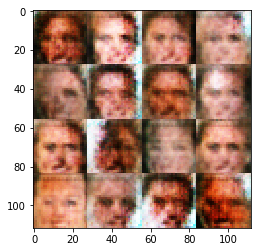

Step: 1310: Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 0.6299
Step: 1320: Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.6775
Step: 1330: Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.7619
Step: 1340: Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.7113
Step: 1350: Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 0.7235
Step: 1360: Epoch 1/2... Discriminator Loss: 1.4043... Generator Loss: 0.7105
Step: 1370: Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.7817
Step: 1380: Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.6991
Step: 1390: Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.6194
Step: 1400: Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.6606


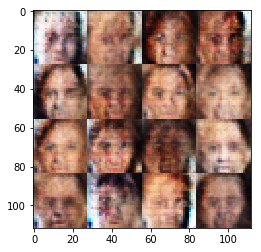

Step: 1410: Epoch 1/2... Discriminator Loss: 1.4416... Generator Loss: 0.7489
Step: 1420: Epoch 1/2... Discriminator Loss: 1.4110... Generator Loss: 0.6259
Step: 1430: Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.7508
Step: 1440: Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.5635
Step: 1450: Epoch 1/2... Discriminator Loss: 1.4919... Generator Loss: 0.7011
Step: 1460: Epoch 1/2... Discriminator Loss: 1.6375... Generator Loss: 0.4693
Step: 1470: Epoch 1/2... Discriminator Loss: 1.4380... Generator Loss: 0.6893
Step: 1480: Epoch 1/2... Discriminator Loss: 1.4275... Generator Loss: 0.5780
Step: 1490: Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.6158
Step: 1500: Epoch 1/2... Discriminator Loss: 1.4246... Generator Loss: 0.6825


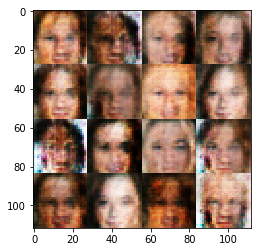

Step: 1510: Epoch 1/2... Discriminator Loss: 1.4293... Generator Loss: 0.7102
Step: 1520: Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.6855
Step: 1530: Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 0.6285
Step: 1540: Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.6771
Step: 1550: Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.7067
Step: 1560: Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 0.6801
Step: 1570: Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 0.7040
Step: 1580: Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.6686
Step: 1590: Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.6208
Step: 1600: Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.7204


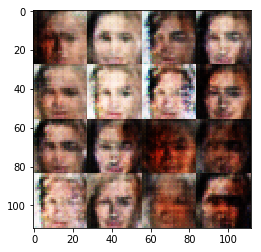

Step: 1610: Epoch 2/2... Discriminator Loss: 1.4330... Generator Loss: 0.5839
Step: 1620: Epoch 2/2... Discriminator Loss: 1.4748... Generator Loss: 0.6281
Step: 1630: Epoch 2/2... Discriminator Loss: 1.4159... Generator Loss: 0.6396
Step: 1640: Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.6760
Step: 1650: Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.7108
Step: 1660: Epoch 2/2... Discriminator Loss: 1.4007... Generator Loss: 0.6583
Step: 1670: Epoch 2/2... Discriminator Loss: 1.4689... Generator Loss: 0.6079
Step: 1680: Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.6810
Step: 1690: Epoch 2/2... Discriminator Loss: 1.4854... Generator Loss: 0.6085
Step: 1700: Epoch 2/2... Discriminator Loss: 1.4410... Generator Loss: 0.6369


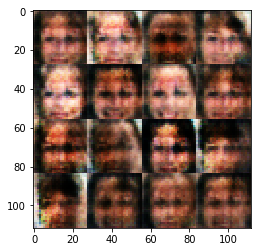

Step: 1710: Epoch 2/2... Discriminator Loss: 1.4702... Generator Loss: 0.7827
Step: 1720: Epoch 2/2... Discriminator Loss: 1.5649... Generator Loss: 0.5799
Step: 1730: Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.7931
Step: 1740: Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.6207
Step: 1750: Epoch 2/2... Discriminator Loss: 1.4596... Generator Loss: 0.6056
Step: 1760: Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.6997
Step: 1770: Epoch 2/2... Discriminator Loss: 1.4663... Generator Loss: 0.6446
Step: 1780: Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.6113
Step: 1790: Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.7413
Step: 1800: Epoch 2/2... Discriminator Loss: 1.4030... Generator Loss: 0.6831


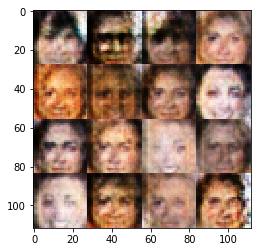

Step: 1810: Epoch 2/2... Discriminator Loss: 1.4118... Generator Loss: 0.7227
Step: 1820: Epoch 2/2... Discriminator Loss: 1.4552... Generator Loss: 0.6488
Step: 1830: Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.7596
Step: 1840: Epoch 2/2... Discriminator Loss: 1.4196... Generator Loss: 0.7002
Step: 1850: Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.7215
Step: 1860: Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.5724
Step: 1870: Epoch 2/2... Discriminator Loss: 1.4338... Generator Loss: 0.6328
Step: 1880: Epoch 2/2... Discriminator Loss: 1.3985... Generator Loss: 0.7269
Step: 1890: Epoch 2/2... Discriminator Loss: 1.4211... Generator Loss: 0.7409
Step: 1900: Epoch 2/2... Discriminator Loss: 1.4288... Generator Loss: 0.6352


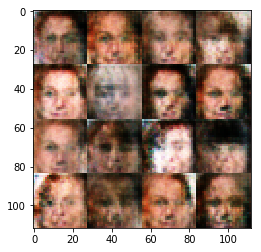

Step: 1910: Epoch 2/2... Discriminator Loss: 1.4304... Generator Loss: 0.7557
Step: 1920: Epoch 2/2... Discriminator Loss: 1.4183... Generator Loss: 0.6991
Step: 1930: Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.5855
Step: 1940: Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.7025
Step: 1950: Epoch 2/2... Discriminator Loss: 1.4955... Generator Loss: 0.5568
Step: 1960: Epoch 2/2... Discriminator Loss: 1.4634... Generator Loss: 0.5866
Step: 1970: Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.7208
Step: 1980: Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 0.5846
Step: 1990: Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.7023
Step: 2000: Epoch 2/2... Discriminator Loss: 1.4736... Generator Loss: 0.6409


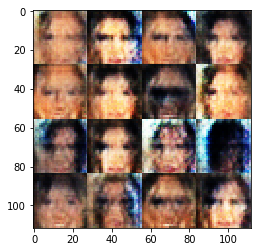

Step: 2010: Epoch 2/2... Discriminator Loss: 1.4561... Generator Loss: 0.7290
Step: 2020: Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.6505
Step: 2030: Epoch 2/2... Discriminator Loss: 1.4837... Generator Loss: 0.6328
Step: 2040: Epoch 2/2... Discriminator Loss: 1.4139... Generator Loss: 0.6528
Step: 2050: Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.6720
Step: 2060: Epoch 2/2... Discriminator Loss: 1.5061... Generator Loss: 0.5171
Step: 2070: Epoch 2/2... Discriminator Loss: 1.4685... Generator Loss: 0.6039
Step: 2080: Epoch 2/2... Discriminator Loss: 1.4479... Generator Loss: 0.6286
Step: 2090: Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7659
Step: 2100: Epoch 2/2... Discriminator Loss: 1.4691... Generator Loss: 0.6187


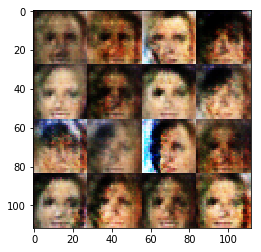

Step: 2110: Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 0.7357
Step: 2120: Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.7026
Step: 2130: Epoch 2/2... Discriminator Loss: 1.5040... Generator Loss: 0.6784
Step: 2140: Epoch 2/2... Discriminator Loss: 1.4810... Generator Loss: 0.7263
Step: 2150: Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.7134
Step: 2160: Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.7231
Step: 2170: Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.6286
Step: 2180: Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.7136
Step: 2190: Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.6473
Step: 2200: Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.6545


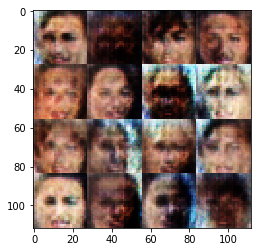

Step: 2210: Epoch 2/2... Discriminator Loss: 1.4231... Generator Loss: 0.6387
Step: 2220: Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.6914
Step: 2230: Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6562
Step: 2240: Epoch 2/2... Discriminator Loss: 1.3935... Generator Loss: 0.6446
Step: 2250: Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.7413
Step: 2260: Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.6994
Step: 2270: Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.6659
Step: 2280: Epoch 2/2... Discriminator Loss: 1.3593... Generator Loss: 0.6226
Step: 2290: Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.7303
Step: 2300: Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.7317


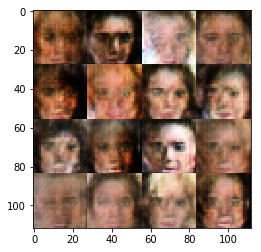

Step: 2310: Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.7470
Step: 2320: Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.5910
Step: 2330: Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.6954
Step: 2340: Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.7016
Step: 2350: Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.6797
Step: 2360: Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 0.6820
Step: 2370: Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.6811
Step: 2380: Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.6939
Step: 2390: Epoch 2/2... Discriminator Loss: 1.4062... Generator Loss: 0.6946
Step: 2400: Epoch 2/2... Discriminator Loss: 1.4240... Generator Loss: 0.7049


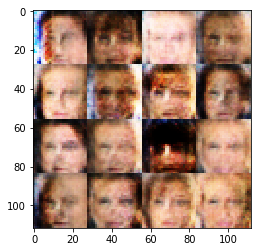

Step: 2410: Epoch 2/2... Discriminator Loss: 1.4521... Generator Loss: 0.6317
Step: 2420: Epoch 2/2... Discriminator Loss: 1.5314... Generator Loss: 0.5523
Step: 2430: Epoch 2/2... Discriminator Loss: 1.4350... Generator Loss: 0.6771
Step: 2440: Epoch 2/2... Discriminator Loss: 1.3884... Generator Loss: 0.7091
Step: 2450: Epoch 2/2... Discriminator Loss: 1.4432... Generator Loss: 0.6679
Step: 2460: Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.6811
Step: 2470: Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.7199
Step: 2480: Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.7146
Step: 2490: Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 0.6560
Step: 2500: Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.7040


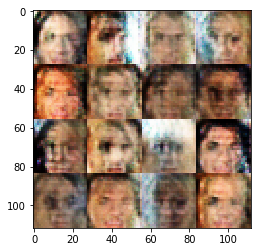

Step: 2510: Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 0.6748
Step: 2520: Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.6961
Step: 2530: Epoch 2/2... Discriminator Loss: 1.3823... Generator Loss: 0.6767
Step: 2540: Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.6847
Step: 2550: Epoch 2/2... Discriminator Loss: 1.4204... Generator Loss: 0.6975
Step: 2560: Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.7821
Step: 2570: Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.6394
Step: 2580: Epoch 2/2... Discriminator Loss: 1.4084... Generator Loss: 0.6761
Step: 2590: Epoch 2/2... Discriminator Loss: 1.4092... Generator Loss: 0.7093
Step: 2600: Epoch 2/2... Discriminator Loss: 1.4371... Generator Loss: 0.7543


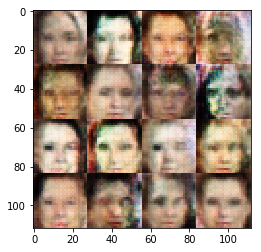

Step: 2610: Epoch 2/2... Discriminator Loss: 1.4128... Generator Loss: 0.6259
Step: 2620: Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.6924
Step: 2630: Epoch 2/2... Discriminator Loss: 1.3960... Generator Loss: 0.6589
Step: 2640: Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.6610
Step: 2650: Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.6902
Step: 2660: Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 0.7153
Step: 2670: Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.6579
Step: 2680: Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.6793
Step: 2690: Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.7085
Step: 2700: Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.7202


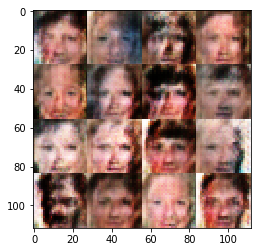

Step: 2710: Epoch 2/2... Discriminator Loss: 1.4007... Generator Loss: 0.7793
Step: 2720: Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.7051
Step: 2730: Epoch 2/2... Discriminator Loss: 1.4447... Generator Loss: 0.6676


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.